In [2]:
# Import packages and other setup
from pvc import Dataset, query, load
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns
import datetime as dt
from sklearn.metrics import mean_squared_error
from scipy import stats
import pickle

In [3]:
plt.rcParams['figure.figsize'] = (15,10)
sns.set()

## Dummy dataset functions

In [4]:
def normal_samples(num_samples, mu = 0.8, sigma = 0.2):
    s = np.random.normal(mu, sigma, num_samples)
    s = np.clip(s, a_min = 0, a_max = 1)
    return s

In [5]:
def uniform_samples(num_samples, low=0, high=1):
    s = np.random.uniform(low,high,num_samples)
    return s

In [6]:
#create some dummy data for experimentation with a fixed spend rate
def dummy_dataset(num_samples):
    df = pd.DataFrame()
    df['value'] = normal_samples(num_samples)
    df['competing_bid'] = normal_samples(num_samples,0.6,0.3)
    #df['competing_bid'] = uniform_samples(num_samples,0.3,0.6)
    return df

In [7]:
#create some dummy data for experimentation with a changing spend rate
def changing_spend_dummy_dataset(num_samples):
    if int(num_samples)%10:
        raise Exception("num_samples should be a multiple of 10")
    num_samples = (int)(num_samples/10)
    val = np.empty((0))
    for i in range(10):
        val = np.append(val, uniform_samples(num_samples, 1 + 0.1*i, 2 + 0.1*i))
    df = pd.DataFrame()
    df['value'] = val
    df['competing_bid'] = 1
    return df

In [8]:
#returns the approximate spend rate by using for a data_sampler
def approximate_spend_rate(data_sampler, budget, num_samples, num_trials):
    spend_curve = np.zeros((num_samples))
    for i in range(num_trials):
        ss = data_sampler(num_samples)
        dft = hindsight_strategy(ss, budget)
        spend_curve += dft['spend']
    spend_sum = np.sum(spend_curve)
    if spend_sum != 0:
        spend_curve = (spend_curve/spend_sum)*budget
    return spend_curve

# Pacing algorithms

## Hindsight strategy

In [9]:
#ex. post optimal strategy
def hindsight_strategy(df = dummy_dataset(100), budget = 15):		
    """ A function to implement the ex. post optimal pacing strategy for a budget constraint campaign
    Sorts the impressions by value/competing bid and buys all top impressions till runs out of budget

    Args:
        df: The imput dataframe containing 'value' and 'competing_bid' with each row as one impression
        budget: The total budget for the campaign

    Returns:
        A dataframe containing with the following columns for each impression
        bang_per_buck: The value per dollar for the impression
        won: A binary flag indicating if the impression was won
        spend: Spend in this round
        utility: Utility obtained in this round
        paced_impression_bid: Paced bid
        value_obtianed: value_obtained in this round (i.e value*won)
        pacing_multiplier: The pacing multiplier used to obtained the shaded bid
        index: The index of the impression in the input data

    """
    df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
    df = df.sort_values(by = 'bang_per_buck', ascending=False)
    df['utility'] = 0
    df['won'] = False
    df['spend'] = 0
    shade = 1.0
    for index,row in df.iterrows():
        if budget-row['competing_bid'] >=0 and row['bang_per_buck']>0:
            row['won'] = True
            row['utility'] = row['value'] - row['competing_bid']
            if row['competing_bid']==0:
                shade = np.infty
            else:
                shade = row['value']/row['competing_bid']
            budget = budget - row['competing_bid']
            df.loc[index] = row
        else:
            break
    #print(shade)
    df['paced_bid'] = df['value']/shade
    df.sort_index(inplace=True)
    df['spend'] = df['competing_bid']*df['won']
    df['index'] = df.index
    df['value_obtained'] = df['value']*df['won']
    df['pacing_multiplier'] = 1.0/shade
    #print(df.head())
    return df

## Adaptive pacing

In [10]:
#No regret adaptive pacing strategy
def adaptive_pacing_bg(df, target_spend, learning_rate = 0.001):
    """ A function to simulate an adaptive pacing strategy which attempts match the target spend

    Args:
        df: The imput dataframe containing 'value' and 'competing_bid' with each row as one impression
        target_spend: instantaneous target spend (not cumulative)

    Returns:
        A dataframe containing with the following columns for each impression
        won: A binary flag indicating if the impression was won
        spend: Spend in this round
        target_spend: Target spend rate in this round
        utility: Utility obtained in this round
        paced_bid: Paced impression bid
        value_obtained: value_obtained in this round (i.e value*won)
        pacing_multiplier: The pacing multiplier used to obtained the shaded bid
        index: The index of the impression in the input data
    """
        
    max_shading = 100
    budget = np.sum(target_spend)
    cur_shading = 0.01
    df['pacing_multiplier'] = 0
    df['utility'] = 0
    df['won'] = False
    df['target_spend'] = target_spend
    df['paced_bid'] = 0
    df['spend'] = 0
    #learning_rate = 1/np.sqrt(df.shape[0]+1)
    #learning_rate = 0.1
    for index,row in df.iterrows():
        row['paced_bid'] = min(row['value']/(1 + cur_shading), budget)
        if row['paced_bid']==0:
            row['pacing_multiplier'] = 0
        else:
            row['pacing_multiplier'] = row['paced_bid']/row['value']
        if row['paced_bid']>=row['competing_bid']:
            budget = budget - row['competing_bid']
            row['won'] = True
            row['utility'] = row['value'] - row['competing_bid']
            row['spend'] = row['competing_bid']
        cur_shading = cur_shading - learning_rate*(row['target_spend']-row['spend'])
        cur_shading = np.clip(cur_shading, a_min = 0, a_max = max_shading)
        df.loc[index] = row
    df['index'] = df.index
    df['value_obtained'] = df['value']*df['won']
    #print(df.head())
    return df

## Running simulator using dummy data

In [15]:
# generate dummy data
num_samples  = 1000
budget = num_samples/2
num_trials = 100
data = changing_spend_dummy_dataset(num_samples)
# Learn the spend rate for this dummy data
target_spend = approximate_spend_rate(changing_spend_dummy_dataset, budget = budget, num_samples = num_samples, num_trials = num_trials)

In [25]:
# Running the apative pacing algorithm
df_adapt = adaptive_pacing_bg(data, target_spend, learning_rate = 0.1)
# Extra dfs for plotting
df_adapt_cum = df_adapt[ [ 'utility', 'spend','value_obtained']].cumsum()
df_adapt_cum['index'] = df_adapt_cum.index
df_adapt_tidy =  pd.melt(df_adapt_cum, id_vars=['index'], var_name='cols', value_name = 'cumm_value')

In [26]:
# Running the hindsight algorithm
df_hindsight = hindsight_strategy(data, budget = budget)
# Extra dfs for plotting
df_hindsight_cum = df_hindsight[ [ 'utility', 'spend','value_obtained']].cumsum()
df_hindsight_cum['index'] = df_hindsight_cum.index
df_hindsight_tidy =  pd.melt(df_hindsight_cum, id_vars=['index'], var_name='cols', value_name = 'cumm_value')

In [27]:
df_plot = pd.concat([df_adapt_tidy.assign(dataset='adapt'), df_hindsight_tidy.assign(dataset='hindsight')])
df_plot ['col'] = df_plot[['cols', 'dataset']].apply(lambda x: '_'.join(x), axis = 1)

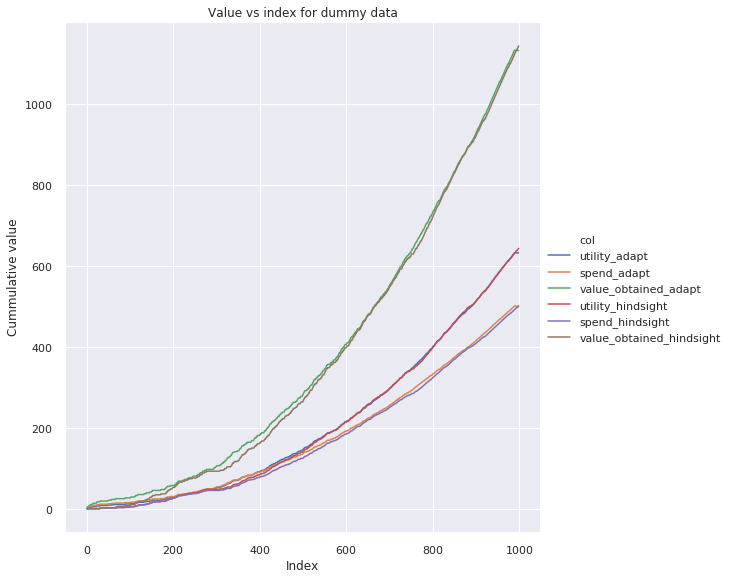

In [30]:
ax = sns.relplot(
    x="index",
    y="cumm_value",
    kind="line",
    hue = 'col',
    height=8,
    data=df_plot
    )
ax.set(xlabel='Index', ylabel='Cummulative value', title='Value vs index for dummy data')

Percent regret variable: 1.739874


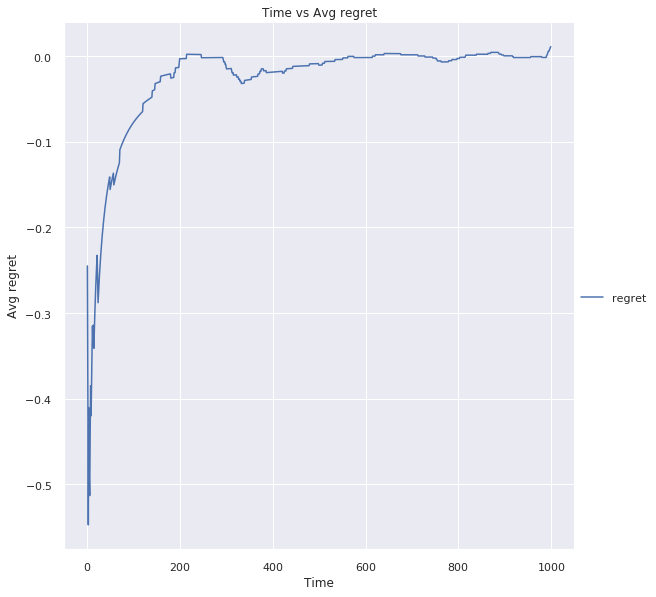

In [31]:
df_regret = pd.DataFrame()
df_regret['regret'] = df_hindsight_cum['utility'] - df_adapt_cum['utility']
df_regret['regret'] =  df_regret['regret']/np.array(list(range(1, df_regret.shape[0]+1)))
ax = sns.relplot(
    kind="line",
    hue = 'col',
    height=8,
    data=df_regret
    )
ax.set(xlabel='Time', ylabel='Avg regret', title='Time vs Avg regret')

hindsight_total_val = df_hindsight_cum['utility'].iloc[-1]
var_total_val = df_adapt_cum['utility'].iloc[-1]
print("Percent regret variable: %f" % ((hindsight_total_val - var_total_val)*100/hindsight_total_val) )

# Learning OC for fixed data
We simulate the hindsight strategy to get the spend rate. Since just running the hindsight strategy once will lead to a non-continuous spen curve, to obtain a smooth version which we can use for in the adaptive pacing algorithm, we use subsampling. To learn the spend rate, we sample some of the rounds from the data, we scale the budget according to the sampling probability. We run the hindsight strategy with the scaled budget on the sampled rounds and we interpolate the spend for the rounds not sampled. We repeat this process multiple times and take the average to get the spend curve. Then we smooth the cruve by taking a rolling mean.

In [11]:
def approximate_spend_rate_from_dataset(dataset, sampling_probability, budget, num_trials, smoothing_window_size = 7):
    """
    Learns the spend rate (OC) from the dataset:
    
    Args:
        dataset: dataset for which we need to learn the OC (dataframe with value, competing_bid)
        sampling_probability: probability by which each round is sampled in a trial
        budget: budget of the dataset
        num_trials: Number of times the hindsight strategy is ran on a sampled set
        smoothing_window_size: rolling window size for rolling mean
        
    Returns:
        spend curve (OC) as numpy array with the same size as that of the number of rows in the dataset
        
    """
    total_impressions = dataset.shape[0]
    num_samples = int(total_impressions*sampling_probability)
    sampling_positions = (np.array(list(range(num_samples)))/sampling_probability).astype(int)
    scaled_budget = budget*sampling_probability
    sampled_spend = np.zeros(num_samples)
    for _i in range(num_trials):
        sampling_indices = sorted(np.random.choice(total_impressions, num_samples, replace=False))
        sampled_data = dataset.iloc[sampling_indices]
        dft = hindsight_strategy(sampled_data, scaled_budget)
        #print(dft['spend'].sum())
        sampled_spend += dft['spend'].values
    #return sampled_spend
    sampled_spend = sampled_spend/num_trials
    spend_curve = np.interp(list(range(total_impressions)), sampling_positions, sampled_spend)
    spend_cruve = average_spend_smoothing(spend_curve, smoothing_window_size)
    spend_sum = np.sum(spend_curve)
    if spend_sum != 0:
        spend_curve = (spend_curve/spend_sum)*budget
    return spend_curve

In [12]:
def average_spend_smoothing(target_spend, window_size = 7):
    """
    Rolling mean for the spend
    """
    if int(window_size)%2 != 1:
        raise Exception("window_size should be an odd number")
    padding_len = int((window_size-1)/2)
    left_padding = [target_spend[0]]* padding_len 
    right_padding = [target_spend[-1]]*padding_len 
    padded_target_spend = np.append(left_padding, target_spend)
    padded_target_spend = np.append(padded_target_spend,right_padding)
    target_spend_df = pd.DataFrame(padded_target_spend)
    return target_spend_df.rolling(window=window_size).mean().iloc[window_size-1:].values

## Linear OC

In [13]:
def linear_spend_rate(budget, num_rounds):
    """
    Linear OC. Assumes interarrival time between the impressions is uniform.
    
    Args:
        budget: budget to be divided
        num_rounds: number of rounds the budget needs to be divided into

    Returns:
        Linear (OC)
        
    """
    
    return [budget/num_samples]*num_rounds

# Regret

## Value regret

In [14]:
def paced_regret(hindsight_df, pacing_df):
    """
    Final value regret. Returns percent regret measured with respect to the hindsight value
    """
    hindsight_total_val = hindsight_df['value_obtained'].sum()
    paced_total_val = pacing_df['value_obtained'].sum()
    return ((hindsight_total_val - paced_total_val)*100/hindsight_total_val) 

## Utility regret

In [15]:
def paced_regret_u(hindsight_df, pacing_df):
    """
    Final utility regret. Returns percent regret measured with respect to the hindsight value
    """
    hindsight_total_val = hindsight_df['utility'].sum()
    paced_total_val = pacing_df['utility'].sum()
    return ((hindsight_total_val - paced_total_val)*100/hindsight_total_val) 

Specify the OCs methods

- 'var' : Learned OC from data
- 'lin' : Linear OC (Also the Balseiro & Gur setting)
- 'mix_x' : Convex combination with x part linear and 1-x part learned

In [16]:
OCs = ['var','mix_0.5','lin']

In [17]:
transformed_df = changing_spend_dummy_dataset(1000)

Specify the budget fraction to specify the budget of our problem, a budget fraction 1 means we can buy all impressions, a ratio x means we have x fraction of the budget required to buy all fractions

In [18]:
budget_frac = 0.7

In [20]:
total_budget = transformed_df['competing_bid'].sum()
budget = total_budget*budget_frac

### Generate the spend rates (OC)

In [21]:
num_samples = transformed_df.shape[0]

Linear spend curve

In [22]:
target_lin_spend = linear_spend_rate(budget, num_samples)

Lerned spend curve

In [23]:
target_var_spend = approximate_spend_rate_from_dataset(dataset = transformed_df, sampling_probability =  0.2 , budget = budget, num_trials = 20)

/data/users/bhuvesh/.bento/kernels/bento_kernel_default/latest/bento_kernel_default:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Run Hindsight strategy

In [25]:
campaign = '1'
paced_df = {}
paced_df[campaign] = {}
paced_df[campaign][budget_frac] = {}
data = transformed_df
paced_df[campaign][budget_frac]['hindsight'] = hindsight_strategy(data.copy(), budget = budget)

### Run adaptive pacing for all the OCs

In [30]:
learning_rate = 0.1
for OC in OCs:
    print(OC)
    if OC == 'var':
        adaptive_pacing_df = adaptive_pacing_bg(data.copy(), target_var_spend, learning_rate)
    elif OC == 'lin':
        adaptive_pacing_df = adaptive_pacing_bg(data.copy(), target_lin_spend, learning_rate)
    else:
        alpha = float(OC.split("_")[-1])
        # Mixed spend by taking convex combination
        mixed_spend = alpha * np.array(target_lin_spend) + (1-alpha)*np.array(target_var_spend)
        adaptive_pacing_df = adaptive_pacing_bg(data.copy(), mixed_spend, learning_rate)
    paced_df[campaign][budget_frac][OC] = adaptive_pacing_df.copy()

var
mix_0.5
lin


In [227]:
# Pickle dump the paced_df for future if needed
with open('./raw_data/paced_df_' + campaign + str(budget_frac), 'wb') as handle:
          pickle.dump(paced_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Plotting the data

Specify the cummulative colums to be plotted

In [31]:
columns_plot = ['value_obtained', 'spend']

## Use utilty for the paper
# columns_plot = ['utilility', 'spend']

In [32]:
df_cum = paced_df[campaign][budget_frac]['hindsight'][ columns_plot ].cumsum()
df_cum['index'] = df_cum.index
df_tidy =  pd.melt(df_cum, id_vars=['index'], var_name='cols', value_name = 'cumm_value')
df_tidy['OC'] = 'hindsight'
df_plot = df_tidy.copy()
for OC in OCs:
    df_cum = paced_df[campaign][budget_frac][OC][ columns_plot ].cumsum()
    df_cum['index'] = df_cum.index
    df_tidy =  pd.melt(df_cum, id_vars=['index'], var_name='cols', value_name = 'cumm_value')
    df_tidy['OC'] = OC
    df_plot = pd.concat([df_plot, df_tidy])

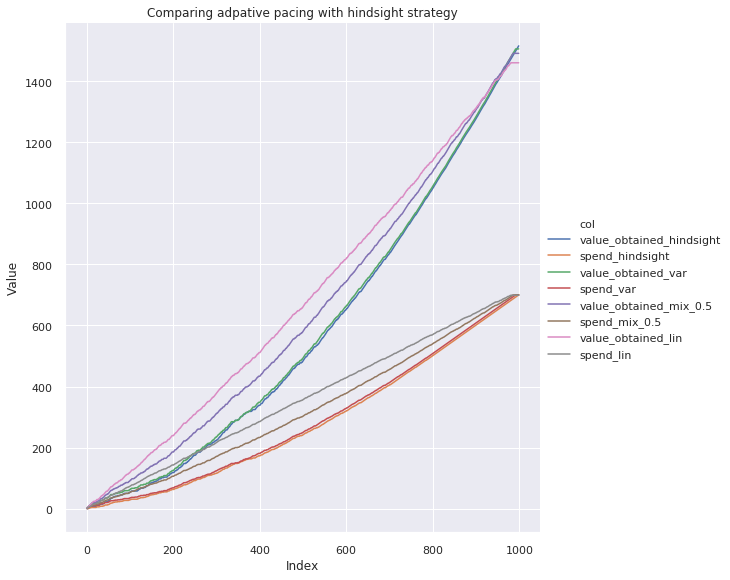

In [33]:
df_plot['col'] = df_plot[['cols', 'OC']].apply(lambda x: '_'.join(x), axis = 1)

ax = sns.relplot(
x ='index',
y ='cumm_value',
kind ='line',
hue = 'col',
height = 8,
data = df_plot
)
ax.set(xlabel='Index', ylabel='Value', title='Comparing adpative pacing with hindsight strategy')

### Plotting average regret

Select the variable for regret

In [34]:
regret_variable = 'value_obtained'
# Use utility for the paper
#regret_variable = 'utility'

if regret_variable=='value_obtained':
    reg_fun = paced_regret
elif regret_variable=='utility':
    reg_fun = paced_regret_u

Calculate average regret for each OC

In [35]:
df_hindsight_cum = paced_df[campaign][budget_frac]['hindsight'][regret_variable].cumsum()
df_regret = pd.DataFrame()
for OC in OCs:
    df_adapt_cum = paced_df[campaign][budget_frac][OC][regret_variable].cumsum()
    #print(df_adapt_cum)
    df_regret[OC] = df_hindsight_cum - df_adapt_cum
    df_regret[OC] =  df_regret[OC]/np.array(list(range(1, df_regret.shape[0]+1)))
    
    print("Percentage regret for %s is %f"%(OC, reg_fun(paced_df[campaign][budget_frac]['hindsight'], paced_df[campaign][budget_frac][OC])  ))

Percentage regret for var is 0.657372
Percentage regret for mix_0.5 is 1.615914
Percentage regret for lin is 3.657187


Tidy the dataframe and plot

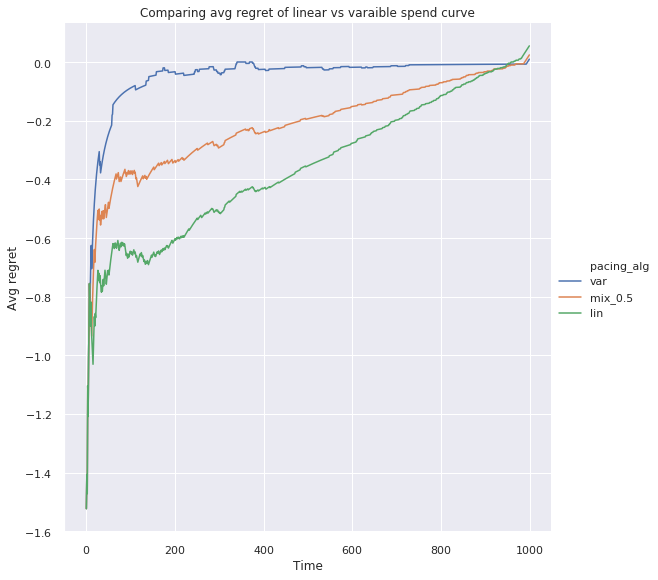

In [36]:
df_regret['index'] = df_regret.index
df_regret_tidy =  pd.melt(df_regret, id_vars=['index'], var_name='pacing_alg', value_name = 'avg_regret')

ax = sns.relplot(
kind="line",
x="index",
y="avg_regret",
hue = 'pacing_alg',
height=8,
data=df_regret_tidy
)
ax.set(xlabel='Time', ylabel='Avg regret', title='Comparing avg regret of linear vs varaible spend curve')